In [1]:
import itertools
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import chisquare

In [2]:
# Define the possible values for year, track type, and polarity
years = [16, 17, 18]
track_types = ['LL', 'DD']
magnet_polarities = ['MU', 'MD']

# Base file path template
template_path = '/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL{year}{tracktype}{polarity}/LPT_procTuple.root'

# This dictionary can hold the file handles
file_handles = {}

# Make every combination of years, tracktype & polarity
for year in years:
    for track_type in track_types:
        for polarity in magnet_polarities:
            # plugs in the all values in the file path
            file_path = template_path.format(year=year, tracktype=track_type, polarity=polarity)
            
            # This generates the variable name for the file handle
            file_name = f'{year}_{track_type}_{polarity}'
                        
            # Opens the file with uproot.open() and stores the handle in the file_handles dictionary
            file_handles[file_name] = uproot.open(file_path)
            print(f"Opened file {file_name}: {file_path}")

Opened file 16_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL16LLMU/LPT_procTuple.root
Opened file 16_LL_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL16LLMD/LPT_procTuple.root
Opened file 16_DD_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL16DDMU/LPT_procTuple.root
Opened file 16_DD_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL16DDMD/LPT_procTuple.root
Opened file 17_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL17LLMU/LPT_procTuple.root
Opened file 17_LL_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL17LLMD/LPT_procTuple.root
Opened file 17_DD_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL17DDMU/LPT_procTuple.root
Opened file 17_DD_MD: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_MM_MVA/LPT/CL17DDMD/LPT_procTuple.root
Opened file 18_LL_MU: /eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206

In [3]:
#first select variables          

selectvariabels = [
    'JPs_MM', 'JPs_PT', 'Lb_DTF_L0_PV_Lambda0_piplus_PY_0', 'Lb_DTF_L0_PV_Lambda0_piplus_PX_0', 
    'Lb_DTF_L0_PV_Lambda0_pplus_PX_0', 'Lb_DTF_L0_PV_Lambda0_pplus_PY_0', 'Lb_DTF_L0_PV_M_0', 
    'Lb_DTF_L0_PV_Lambda0_M_0', 'Lb_DTF_L0_PV_Lambda0_piplus_ID_0', 'Lb_DTF_L0_PV_Lambda0_pplus_ID_0', 
    'Lb_DTF_L0_PV_chi2_0', 'Lb_DTF_Lb_PV_Lambda0_P_0', 'Lb_DTF_Lb_L0_PV_Lambda0_decayLength_0', 
    'Lb_DTF_Lb_L0_PV_ctau_0', 'Lb_DTF_Lb_PV_decayLength_0', 'Lb_DTF_Lb_PV_chi2_0', 'Lb_DTF_L0_JPs_PV_M_0', 
    'Lb_DTF_L0_JPs_PV_Lambda0_piplus_PY_0', 'Lb_DTF_L0_JPs_PV_Lambda0_piplus_PX_0', 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PX_0', 
    'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PY_0', 'Lb_DTF_L0_JPs_PV_Lambda0_M_0', 
    'Lb_DTF_L0_JPs_PV_Lambda0_piplus_ID_0', 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0' ]

branches = {}
# Go through the file handles and create branches
for file_name, file_handle in file_handles.items():
    # Extract the branch from the file handle
    branch = file_handle['Lb2JpsiL_mmTuple/DecayTree'].arrays(selectvariabels)
    
    # Define the branch name
    branch_name = file_name  # Extracting the sample name
    
    # Store the branch in the dictionary
    branches[branch_name] = branch

# Print the branches for each file
for branch_name, branch in branches.items():
    print(f"{branch_name} = {branch}")  

    
# for the charged hadrons I must apply a cut on a varible not yet in the branches

def calculate_protonpt(sample):
    prx_var = 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PX_0'
    pry_var = 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PY_0'
    prt_var = 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PT_0'
    
    prx_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PX_0'
    pry_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PY_0'
    prt_var1 = 'Lb_DTF_L0_PV_Lambda0_pplus_PT_0'
    
    prx_values = branches[sample][prx_var]
    pry_values = branches[sample][pry_var]
    prt_values = np.sqrt(prx_values**2 + pry_values**2)
    branches[sample][prt_var] = prt_values
    
    prx_values1 = branches[sample][prx_var1]
    pry_values1 = branches[sample][pry_var1]
    prt_values1 = np.sqrt(prx_values1**2 + pry_values1**2)
    branches[sample][prt_var1] = prt_values1
    
# Calculate new proton pT variables for each sample
for branch_name in branches:
    calculate_protonpt(branch_name)

# for the pions
def calculate_pionpt(sample):
    pix_var = 'Lb_DTF_L0_JPs_PV_Lambda0_piplus_PX_0'
    piy_var = 'Lb_DTF_L0_JPs_PV_Lambda0_piplus_PY_0'
    pit_var = 'Lb_DTF_L0_JPs_PV_Lambda0_piplus_PT_0'

    pix_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PX_0'
    piy_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PY_0'
    pit_var1 = 'Lb_DTF_L0_PV_Lambda0_piplus_PT_0'
             
    pix_values = branches[sample][pix_var]
    piy_values = branches[sample][piy_var]
    pit_values = np.sqrt(pix_values**2 + piy_values**2)
    branches[sample][pit_var] = pit_values
    
    pix_values1 = branches[sample][pix_var1]
    piy_values1 = branches[sample][piy_var1]
    pit_values1 = np.sqrt(pix_values1**2 + piy_values1**2)
    branches[sample][pit_var1] = pit_values1
    
# Calculate new pion pT variables for each sample
for branch_name in branches:
    calculate_pionpt(branch_name)
    
plotvariables = selectvariabels
new_variables = ['Lb_DTF_L0_JPs_PV_Lambda0_piplus_PT_0', 'Lb_DTF_L0_PV_Lambda0_piplus_PT_0',
                 'Lb_DTF_L0_JPs_PV_Lambda0_pplus_PT_0', 'Lb_DTF_L0_PV_Lambda0_pplus_PT_0']
# add the newly made variables to the arays
plotvariables.extend(new_variables)

#Now apply a transverse momentum treshold on the LL samples
pt_treshhold = 500
cut_branch = {}
for branch_name, branch in branches.items():
    # apply a transverse momentum cut:
    piptmask = branch['Lb_DTF_L0_PV_Lambda0_piplus_PT_0'] > pt_treshhold
    prptmask = branch['Lb_DTF_L0_PV_Lambda0_pplus_PT_0'] > pt_treshhold
    mumumask = branch['JPs_PT'] > 2*pt_treshhold
        
    totptmask = piptmask & prptmask & mumumask
    
    if "LL" in branch_name:
        filtered_branch = {}
        for var in plotvariables:
            filtered_branch[var] = branch[var][totptmask]
        
        # Store the filtered branch in cut_branch_LL
        cut_branch[branch_name] = filtered_branch
    else:
        # Directly copy the branch to cut_branch_DD
        cut_branch[branch_name] = branch
        
samples_to_plot = list(cut_branch.keys())

all_data = {var: np.empty(0) for var in plotvariables} 
for sample in samples_to_plot:
    for var in plotvariables:
        Lbdata = cut_branch[sample][var]
        all_data[var] = np.concatenate((all_data[var], Lbdata))

16_LL_MU = [{JPs_MM: 3.1e+03, JPs_PT: 598, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
16_LL_MD = [{JPs_MM: 3.11e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: 2.21e+03}]
16_DD_MU = [{JPs_MM: 2.11e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: 2.21e+03}]
16_DD_MD = [{JPs_MM: 3.07e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
17_LL_MU = [{JPs_MM: 3.09e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
17_LL_MD = [{JPs_MM: 2.96e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: 2.21e+03}]
17_DD_MU = [{JPs_MM: 2.89e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
17_DD_MD = [{JPs_MM: 3.1e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
18_LL_MU = [{JPs_MM: 899, JPs_PT: 3.88e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: 2.21e+03}]
18_LL_MD = [{JPs_MM: 3.08e+03, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: -2.21e+03}]
18_DD_MU = [{JPs_MM: 2.71e+03, JPs_PT: 679, ... Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0: 2.21e+03}]
18_DD_MD = [{JPs_MM: 2.55e+03, ... Lb_DTF_L0

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(


In [4]:
########################################


# Now first the low q2 region 


########################################

In [5]:
def hgauss(x, resonance_mass, scale, ampl, shape):
    
    # this avoids division by zero
    if scale <= 0:
        raise ValueError("Scale parameter must be positive.")
    # Compute the generalized Gaussian
    with np.errstate(divide='ignore', invalid='ignore'):
        result = ampl * np.exp(-np.abs((x - resonance_mass) / scale) ** shape)
        # Replace NaN values with 0 (or handle appropriately)
        result = np.nan_to_num(result, nan=0.0)
    return result

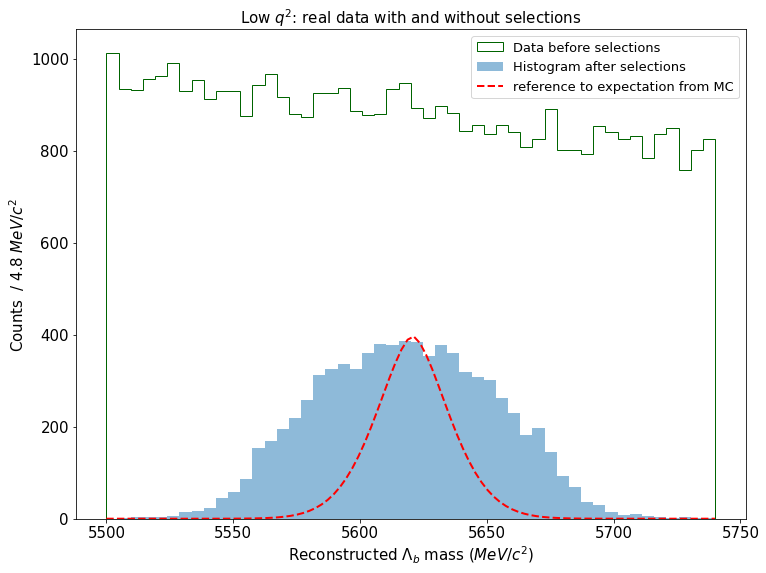

Integral Value: 14489.32, Error: 0.00
120.74


In [12]:
uncut_lbmass = all_data['Lb_DTF_L0_PV_M_0']

mass_muon = 105.66 
lmass_up = 1000*np.sqrt(8) # so that we sit below q2 = 8 GeV^2/c^4
lmass_low = 2* mass_muon   #2*mass_muon # in MeV/c^2  mass cut applied on 'JPs_MM'

lqcutlow = lmass_low < all_data['JPs_MM'] 
lqcuthig = lmass_up > all_data['JPs_MM']
lqmask = lqcutlow & lqcuthig
 
lquncut_lbmass = uncut_lbmass[lqmask]

lqextracut1 = all_data['Lb_DTF_L0_PV_Lambda0_M_0'] < 1115+30
lqextracut2 = all_data['Lb_DTF_L0_PV_Lambda0_M_0'] > 1115-30
lqextracut3 = all_data['Lb_DTF_L0_PV_Lambda0_pplus_ID_0'] == 2212.0
lqextracut4 = all_data['Lb_DTF_L0_PV_Lambda0_piplus_ID_0'] == -211.0
lqextracut5 = all_data['Lb_DTF_Lb_L0_PV_ctau_0'] < 100
lqextracut6 = all_data['Lb_DTF_Lb_PV_chi2_0'] < 30
lqextracut7 = all_data['Lb_DTF_L0_PV_M_0'] > 5500
lqextracut8 = all_data['Lb_DTF_L0_PV_M_0'] < 5740
# The final cut
lqtotal_extra_cut = (lqmask & lqextracut1  & lqextracut2 &  lqextracut3  &  lqextracut4 
                     &lqextracut5 & lqextracut6 & lqextracut7 & lqextracut8) 

lq_lbmass = uncut_lbmass[lqtotal_extra_cut]
histlq, bin_edgeslq = np.histogram(lq_lbmass, bins=50)

plt.figure(figsize = (12,9))
range_ =  (5500, 5740)
bin_width1 = (range_[1]-range_[0])/50

plt.hist(lquncut_lbmass, bins = 50, histtype = 'step',range = range_, linewidth=1, color = 'darkgreen', label = 'Real data before selections')
plt.hist(lq_lbmass, bins = 50,range = range_, linewidth=1, alpha = 0.5, label = 'Real data after selections')

largs = (5620.723477740992,  20.42057909004637, max(histlq),  1.6637659621374825)
x = np.linspace(range_[0], range_[1], 100)
y = hgauss(x, *largs)
plt.plot(x,y, color = 'red', linewidth = 2, ls = '--', label = 'reference to expectation from MC')
plt.xlabel('Reconstructed $\Lambda_b$ mass ($MeV/c^2$)', fontsize = 15)
plt.ylabel(f'Counts  / {bin_width1:.1f} $MeV/c^2$', fontsize = 15)
plt.title(r'Low $q^2$: real data with and without selections', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.show()


integral_limits = (5500, 5740)
bin_width2 = (integral_limits[1]-integral_limits[0])/2
def fitted_function1(x):
    return hgauss(x, *largs)
integral_result1, integral_error1 = quad(fitted_function1, *integral_limits)
print(f"Integral Value: {integral_result1:.2f}, Error: {integral_error1:.2f}")
print(f"{integral_result1/bin_width2:.2f}")

In [ ]:
# Now high q2

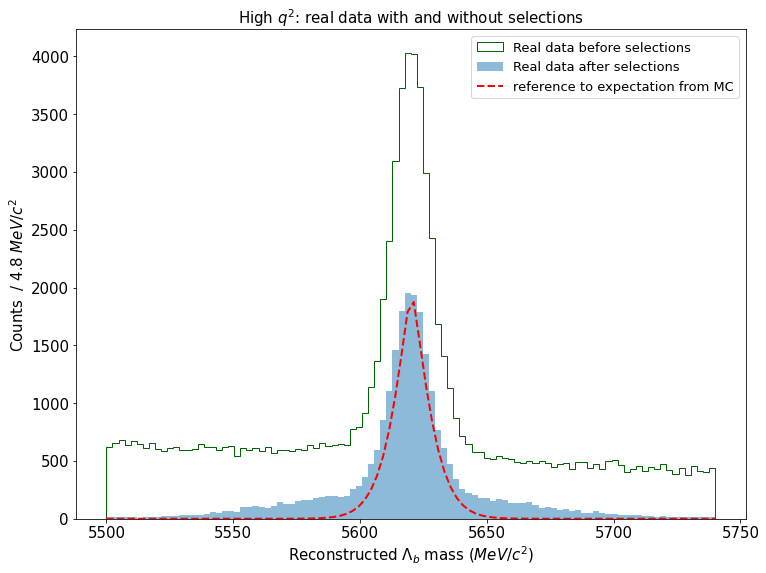

Integral Value: 33377.82, Error: 0.00
278.15


In [14]:
huncut_lbmass = all_data['Lb_DTF_L0_JPs_PV_M_0']

hmass_up = 1000*np.sqrt(11) # so that we sit below q2 = 8 GeV^2/c^4
hmass_low = 1000*np.sqrt(8)   #2*mass_muon # in MeV/c^2  mass cut applied on 'JPs_MM'

hqcutlow = hmass_low < all_data['JPs_MM'] 
hqcuthig = hmass_up > all_data['JPs_MM']
hqmask = hqcutlow & hqcuthig
 
hquncut_lbmass = huncut_lbmass[hqmask]

hqextracut1 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_M_0'] < 1115+30
hqextracut2 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_M_0'] > 1115-30
hqextracut3 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0'] == 2212.0
hqextracut4 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_piplus_ID_0'] == -211.0
hqextracut5 = all_data['Lb_DTF_Lb_L0_PV_ctau_0'] < 100
hqextracut6 = all_data['Lb_DTF_Lb_PV_chi2_0'] < 30
hqextracut7 = all_data['Lb_DTF_L0_JPs_PV_M_0'] > 5500
hqextracut8 = all_data['Lb_DTF_L0_JPs_PV_M_0'] < 5740
# The final cut
hqtotal_extra_cut = (hqmask & hqextracut1  & hqextracut2 &  hqextracut3  &  hqextracut4 
                     & hqextracut5 & hqextracut6 & hqextracut7 & hqextracut8) 

hq_lbmass = huncut_lbmass[hqtotal_extra_cut]
histhq, bin_edgeshq = np.histogram(hq_lbmass, bins=100)

plt.figure(figsize = (12,9))
range_ =  (5500, 5740)
plt.hist(hquncut_lbmass, bins = 100, histtype = 'step',range = range_, linewidth=1, color = 'darkgreen', label = 'Real data before selections')
plt.hist(hq_lbmass, bins = 100,range = range_, linewidth=1, alpha = 0.5, label = 'Real data after selections')

hargs = (5620.306582667498, 9.213389714911015, max(histhq), 1.3159659465677462)
x = np.linspace(range_[0], range_[1], 100)
y = hgauss(x, *hargs)
plt.plot(x,y, color = 'red', linewidth = 2, ls = '--', label = 'reference to expectation from MC')
plt.xlabel('Reconstructed $\Lambda_b$ mass ($MeV/c^2$)', fontsize = 15)
plt.ylabel(f'Counts  / {bin_width1:.1f} $MeV/c^2$', fontsize = 15)
plt.title(r'High $q^2$: real data with and without selections', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.show()

integral_limits = (5500, 5740)
bin_width2 = (integral_limits[1]-integral_limits[0])/2
def fitted_function2(x):
    return hgauss(x, *hargs)
integral_result2, integral_error2 = quad(fitted_function2, *integral_limits)
print(f"Integral Value: {integral_result2:.2f}, Error: {integral_error2:.2f}")
print(f"{integral_result2/bin_width2:.2f}")

In [8]:
#test for distributions 
comcut = all_data['Lb_DTF_PV_M_0'] > 5700
y1 = all_data['Lb_DTF_L0_PV_Lambda0_piplus_ID_0'] == -211.0
y2 = all_data['Lb_DTF_L0_PV_Lambda0_pplus_ID_0'] == 2212.0
y3 = all_data['Lb_DTF_L0_PV_Lambda0_pplus_PT_0'] > 500
y4 = all_data['Lb_DTF_L0_PV_Lambda0_piplus_PT_0'] >500
y5 = all_data['JPs_PT'] > 1000
y6 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_M_0'] < 1115+20
y7 = all_data['Lb_DTF_L0_JPs_PV_Lambda0_M_0'] > 1115-20
#y9 = all_data['Lb_DTF_PV_P_0'] > 100000

lqcutlow = lmass_low < all_data['JPs_MM'] 
lqcuthig = lmass_up > all_data['JPs_MM']
lqmask = lqcutlow & lqcuthig

totalcut = comcut & lqmask & y1 & y2 & y3 & y4 & y5 & y6 & y7 

range__ = (0,200)
variable = 'Lb_DTF_Lb_PV_PV_Z_0'

plt.figure(figsize = (8,6))
plt.hist(all_data[variable], color = 'blue', alpha = 0.5, bins = 100, range = range__)
plt.title(f'Testing the distribution from CL data')
plt.ylabel('frequency')
plt.xlabel(f'distribution of ntuple: {variable}')
plt.show()

KeyError: 'Lb_DTF_PV_M_0'